In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import editdistance
import os
import torch
sns.set_context("talk")


def does_contain_exceptions(string):
    return "reverse echo" in string or \
           "prepend remove_first" in string or \
           "echo remove_first" in string or \
           "prepend reverse" in string

def does_not_contain_exceptions(string):
    return "reverse echo" not in string and \
           "prepend remove_first" not in string and \
           "echo remove_first" not in string and \
           "prepend reverse" not in string

def does_not_contain_exception_functions(string):
    return "reverse" not in string and "echo" not in string and "prepend" not in string \
           and "remove_first" not in string

def does_contain_exception_functions(string):
    return "reverse" in string or "echo" in string or "prepend" in string \
           or "remove_first" in string

def compare(input1, input2):
    return input1 == input2


EPOCHS = [20, 30, 40, 50, 60]
RATIOS = [0, 0.0025, 0.005, 0.01, 0.02, 0.04, 0.08]
SEEDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

0.8012731006160164
0.8769541409993156
0.9034907597535934
0.9174332648870637
0.925201916495551


Text(0.5, 1.0, 'dim. = 128')

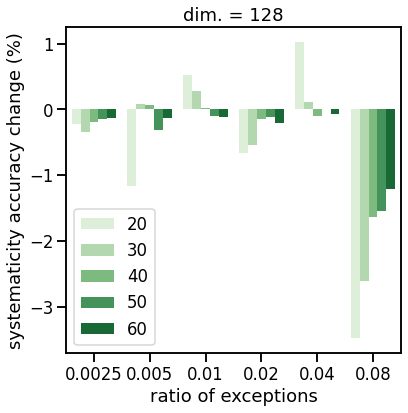

In [2]:
plt.figure(figsize=(6, 6))

def get_result(ratio, seed, model):
    if not os.path.exists(f"../modelling/pcfgset/data/{ratio}_{seed}_{model}/test_iid_{epoch}.src-hyp-tgt"):
        return None
    data = [
        x.split("\t")
        for x in open(
            f"../modelling/pcfgset/data/{ratio}_{seed}_{model}/test_iid_{epoch}.src-hyp-tgt").readlines()
    ]
    if len(data) == 0:
        return None

    result = np.mean([compare(x[1], x[2]) for x in data \
                      if does_not_contain_exceptions(x[0])])

    model = torch.load(f"../modelling/pcfgset/models/{ratio}_{seed}_{model}/checkpoint_last.pt")

    if model["last_optimizer_state"]["state"][0]["step"] < 100000:
        return None
    return result


x_coords, y_coords, hue = [], [], []
for model in ["regular"]:
    for epoch in [20, 30, 40, 50, 60]:
        #print([z[1] for z in [(get_result(0.01, seed, model), seed) for seed in SEEDS] if z[0] is not None])
        zero_result = np.mean([z for z in [get_result(0, seed, model) for seed in SEEDS] if z is not None])
        print(zero_result)
        for seed in SEEDS:
            for k, ratio in enumerate(RATIOS[1:]):
                result = get_result(ratio, seed, model)
                if result is None:
                    continue
                x_coords.append(k)
                y_coords.append(100 * ((result - zero_result) / zero_result))
                hue.append(epoch)

ax = sns.barplot(x=x_coords, y=y_coords, hue=hue, ci=None, palette="Greens")
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(RATIOS[1:])
plt.ylabel("systematicity accuracy change (%)")
plt.xlabel("ratio of exceptions")
#plt.ylim(-0.15, 0.15)
plt.title("dim. = 128")

In [ ]:
import torch

for r in RATIOS:
    for m in ["tiny"]:
        for s in SEEDS:
            if not os.path.exists(f"../modelling/pcfgset/models/{r}_{s}_{m}/checkpoint_last.pt"):
                print(r, m, s, "not exist")
            else:
                model = torch.load(f"../modelling/pcfgset/models/{r}_{s}_{m}/checkpoint_last.pt")
                if model["last_optimizer_state"]["state"][0]["step"] < 100000:
                    print(r, m, s, model["last_optimizer_state"]["state"][0]["step"])
#                 model = torch.load(f"../modelling/pcfgset/models/{r}_{s}_{m}/checkpoint_best.pt")
#                 if model["last_optimizer_state"]["state"][0]["step"] < 100000:
#                     print(r, m, s, model["last_optimizer_state"]["state"][0]["step"])

In [ ]:
plt.figure(figsize=(6, 6))
x_coords, y_coords, hue = [], [], []
for epoch in EPOCHS:
    for model in ["small"]:
        for seed in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            for k, ratio in enumerate(RATIOS):
                if not os.path.exists(f"../modelling/pcfgset/data/{ratio}_{seed}_{model}/test_overgeneralisation_{epoch}.src-hyp-tgt"):
                    continue
                data = [
                    x.split("\t")
                    for x in open(f"../modelling/pcfgset/data/{ratio}_{seed}_{model}/test_overgeneralisation_{epoch}.src-hyp-tgt").readlines()
                ]
                if len(data) == 0:
                    continue

                result = np.mean([compare(x[1], x[2]) for x in data if does_contain_exceptions(x[0])])
                if data:
                    x_coords.append(epoch)
                    y_coords.append(result*100)
                    hue.append(str(ratio))

ax = sns.lineplot(x=x_coords, y=y_coords, hue=hue, palette="Spectral")
plt.legend(title="ratio")
ax.set_xticks(EPOCHS)
plt.ylabel("accuracy of exceptions (%)")
plt.xlabel("epoch")
plt.title("dim. = 256")

In [4]:
colors = sns.color_palette("Spectral", 10)
colors = [colors[0], colors[1], colors[-2], colors[-1]]
colors = {"exc_short": colors[0], "exc_long": colors[1], "org_short": colors[2], "org_long": colors[3]}

In [8]:
def count_functions(source):
    return len([w for w in source.split() if w.lower() == w and w != ","])


def visualise_diff(train_scores, test_scores, postfix, train_scores2):
    x, y, hue, exception = [], [], [], []
    for s in train_scores:
        if s not in train_scores2 or len(train_scores[s]) == 0 or len(test_scores[s]) == 0:
            continue
        x.append(np.mean(train_scores[s]))
        y.append(np.mean(test_scores[s]))
        hue.append(round(np.mean(train_scores2[s]) - np.mean(train_scores[s]), 1))

    x, y, hue = zip(*sorted(zip(x, y, hue), key=lambda z: z[2]))

    data = {'train likelihood': x, 'test likelihood': y, 'large-small': hue}
    grid = sns.jointplot(data=data, x='train likelihood', y='test likelihood',
                  joint_kws={'alpha': 0.1}, linewidth=0, color="white")
    grid.ax_joint.plot([0, 1], [0, 1], linestyle='--', color="black")
    grid.ax_joint.set_xlim(0.8, 1)
    grid.ax_joint.set_ylim(0.6, 0.9)

    functions = ["echo", "copy", "reverse", "swap_first_last", "shift",
                     "append", "prepend", "remove_first", "remove_second", "repeat"]
    letters = set({w for s in train_scores for w in s[0].split() if w.lower() != w})
    names = [f"{f1} {f2}" for f1 in functions for f2 in functions]
    for function in names:
        x, y, hue, exception = [], [], [], []
        for s in train_scores:
            if len(train_scores[s]) < 5 or len(test_scores[s]) < 5 or not function in s[0]:
                continue
            x.append(np.mean(train_scores[s]))
            y.append(np.mean(test_scores[s]))
#             if np.mean(train_scores[s]) - np.mean(test_scores[s]) < 0.1:
#                 print(function, s)
#                 break
        sns.scatterplot(x=[np.nanmean(x)], y=[np.nanmean(y)],
                        ax=grid.ax_joint, alpha=1, color=("red" if function.lower() == function else "green") if len(function.split()) == 1 else "blue")
        plt.text(np.nanmean(x), np.nanmean(y), function)
    plt.show()

In [ ]:
mem1, train_scores1, test_scores1 = load_datasets(model="medium", postfix="_last_ref", start=20, stop=30)
mem2, train_scores2, test_scores2 = load_datasets(model="medium", postfix="_last_ref", start=30, stop=40)

mem1 = Counter({x: y for x, y in mem1.items() if x in mem2})
mem2 = Counter({x: y for x, y in mem2.items() if x in mem1})

print(len(mem1))
easy_examples1 = [x for x in mem1 if mem1[x] < 0.2 and np.mean(train_scores1[x]) > 0.8]
easy_examples2 = [x for x in mem2 if mem2[x] < 0.2 and np.mean(train_scores2[x]) > 0.8]
hard_examples1 = [x for x in mem1 if mem1[x] > 0.8]
hard_examples2 = [x for x in mem2 if mem2[x] > 0.8]
print(len(examples1), len(examples2), len(set(examples1).intersection(set(examples2))))

visualise({x:train_scores2[x] for x in mem1},
          {x:test_scores2[x] for x in mem1}, "_last")

In [ ]:

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

data = {"memorisation": list(mem.values()),
        "length": [len(s[0].split()) for s in mem],
        "exception": ["reverse echo" in s[0] or "prepend remove_first" in s[0] or \
                         "echo remove_first" in s[0] or "prepend reverse" in s[0] for s in mem],
        "group": ["pcfgset"]*len(mem)}

md = smf.mixedlm("memorisation ~ exception", data, groups=data["length"], re_formula="~exception")
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

In [ ]:
x, y = [], []
for src, trg in train_scores1:
    x.append(len(src.split()))
    y.append(len(trg.split()))
grid = sns.jointplot(x=x, y=y, kind="kde")
grid.ax_joint.set_xlim(0, 40)
grid.ax_joint.set_ylim(0, 40)

In [ ]:
ax = sns.distplot(mini_easy)
sns.distplot(mini_hard, ax=ax, color="red")

In [7]:

mem, train_scores, test_scores = load_datasets(model="medium", postfix="_last_ref", start=20, stop=40)
print(len(train_scores))
from nltk import ngrams
src_ngrams, trg_ngrams = Counter(), Counter()
for order in [1, 2, 3, 4, 5]:
    for src, trg in train_scores:
        src_ngrams.update(ngrams(src.split(), order))
        trg_ngrams.update(ngrams(trg.split(), order))

position_freq_src = Counter()
position_freq_trg = Counter()

for s in train_scores:
    for i, c in enumerate(s[0].split()):
        position_freq_src[(i, c)] += 1
for s in train_scores:
    for i, c in enumerate(s[1].split()):
        position_freq_trg[(i, c)] += 1

80540


In [30]:
import scipy.stats
import numpy as np
from statistics import geometric_mean

mem_reg, train_scores_reg, test_scores_reg = load_datasets(model="regular", postfix="_last_ref", start=20, stop=40)
mem_med, train_scores_med, test_scores_med = load_datasets(model="medium", postfix="_last_ref", start=20, stop=40)


def load_features(sentences, start, stop, feature_names=[]):
    X, y_diff, y_mem, y_train, y_test = [], [], [], [], []
    for s in sentences[start:stop]:
        src, trg = s
        features = []
        if "length" in feature_names:
            features.extend([len(src.split()), len(trg.split()),
                        len(src.split()) / len(trg.split()),
                        len(trg.split()) / len(src.split())])
            
        if "bigrams" in feature_names:
            bigrams = list(ngrams(src.split(), 2))
            features.append(np.median([np.log(src_ngrams[x]) for x in bigrams if src_ngrams[x] != 0])
                                if bigrams else 0)
            bigrams = list(ngrams(trg.split(), 2))
            features.append(np.median([np.log(trg_ngrams[x]) for x in bigrams if trg_ngrams[x] != 0])
                                if bigrams else 0)

        if "positions" in feature_names:
            features.append(np.median([np.log(position_freq_src[(i, c)])
                                     for i, c in enumerate(src.split())
                                     if (i, c) in position_freq_src]))
            features.append(np.median([np.log(position_freq_trg[(i, c)])
                                     for i, c in enumerate(trg.split())
                                     if (i, c) in position_freq_trg]))

        if "unique" in feature_names:
            features.append(len(set(s[0].split()))/len(s[0].split()))
            features.append(len(set(s[1].split()))/len(s[1].split()))


        if s in test_scores:
            X.append(features)
            y_diff.append(np.mean(train_scores_reg[s]) - np.mean(train_scores_med[s]))
            y_mem.append(mem_med[s])
            y_train.append(np.mean(train_scores_med[s]))
            y_test.append(np.mean(test_scores_med[s]))
    return X, y_diff, y_mem, y_train, y_test

random.seed(1)
np.random.seed(1)
sentences = [x for x in list(train_scores_reg.keys()) if x in mem_reg and x in mem_med]
random.shuffle(sentences)


from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression

x, y, hue = [], [], []

for names in [["length"], ["bigrams"], ["positions"], ["unique"],
              ["length", "bigrams"], ["length", "positions"], ["length", "unique"],
              ["length", "bigrams", "positions"], ["length", "bigrams", "unique"],
              ["length", "bigrams", "positions", "unique"]]:
    X_train, y_diff, y_mem, y_train, y_test = load_features(sentences, 20000, 80000, names)

    clf = LinearRegression().fit(X_train, y_train)
    prd = clf.predict(X_train)
    rho_test, p_test = scipy.stats.pearsonr(prd, y_train)
    print(names, "train", rho_test)
    x.append(' '.join(names))
    y.append(rho_test)
    hue.append("train")

    clf = LinearRegression().fit(X_train, y_test)
    prd = clf.predict(X_train)
    rho_test, p_test = scipy.stats.pearsonr(prd, y_test)
    print(names, "test", rho_test)
    x.append(' '.join(names))
    y.append(rho_test)
    hue.append("test")

    clf = LinearRegression().fit(X_train, y_mem)
    prd = clf.predict(X_train)
    rho_test, p_test = scipy.stats.spearmanr(prd, y_mem)
    print(names, "mem", rho_test)
    x.append(' '.join(names))
    y.append(rho_test)
    hue.append("mem")

    clf = LinearRegression().fit(X_train, y_diff)
    prd = clf.predict(X_train)
    rho_test, p_test = scipy.stats.pearsonr(prd, y_diff)
    print(names, "size diff", rho_test)
    x.append(' '.join(names))
    y.append(rho_test)
    hue.append("size diff")

['length'] train 0.5917324820038256
['length'] test 0.6945260303224857
['length'] mem 0.5699774449973133
['length'] size diff 0.5541037108513903
['bigrams'] train 0.30037126178782875
['bigrams'] test 0.3259782732215592
['bigrams'] mem 0.2637878454010357
['bigrams'] size diff 0.26781977937373735
['positions'] train 0.6080705028063178
['positions'] test 0.5490933985711527
['positions'] mem 0.49591297014896046
['positions'] size diff 0.5605143481333037
['unique'] train 0.4692581779323046
['unique'] test 0.5485884190798287
['unique'] mem 0.46183672541454934
['unique'] size diff 0.42763453932615336
['length', 'bigrams'] train 0.6288215421664847
['length', 'bigrams'] test 0.7316522804337384
['length', 'bigrams'] mem 0.6094827313766642
['length', 'bigrams'] size diff 0.5861153232815506
['length', 'positions'] train 0.6447371768671727
['length', 'positions'] test 0.7320245009699494
['length', 'positions'] mem 0.6010397749450109
['length', 'positions'] size diff 0.6066778439253329
['length', 'u

In [12]:
scipy.stats.pearsonr([np.mean(train_scores[x]) for x in sentences],
                     [np.mean(test_scores[x]) for x in sentences])

(0.6470934539028191, 0.0)

In [14]:
scipy.stats.pearsonr([np.mean(train_scores[x]) for x in sentences],
                     [np.mean(train_scores[x]) - np.mean(test_scores[x]) for x in sentences])

(-0.4356479019508668, 0.0)

In [16]:
scipy.stats.pearsonr([np.mean(train_scores[x]) for x in sentences],
                     [mem_reg[x] for x in sentences])

(-0.5808804885127724, 0.0)

Text(0, 0.5, "Pearson's r")

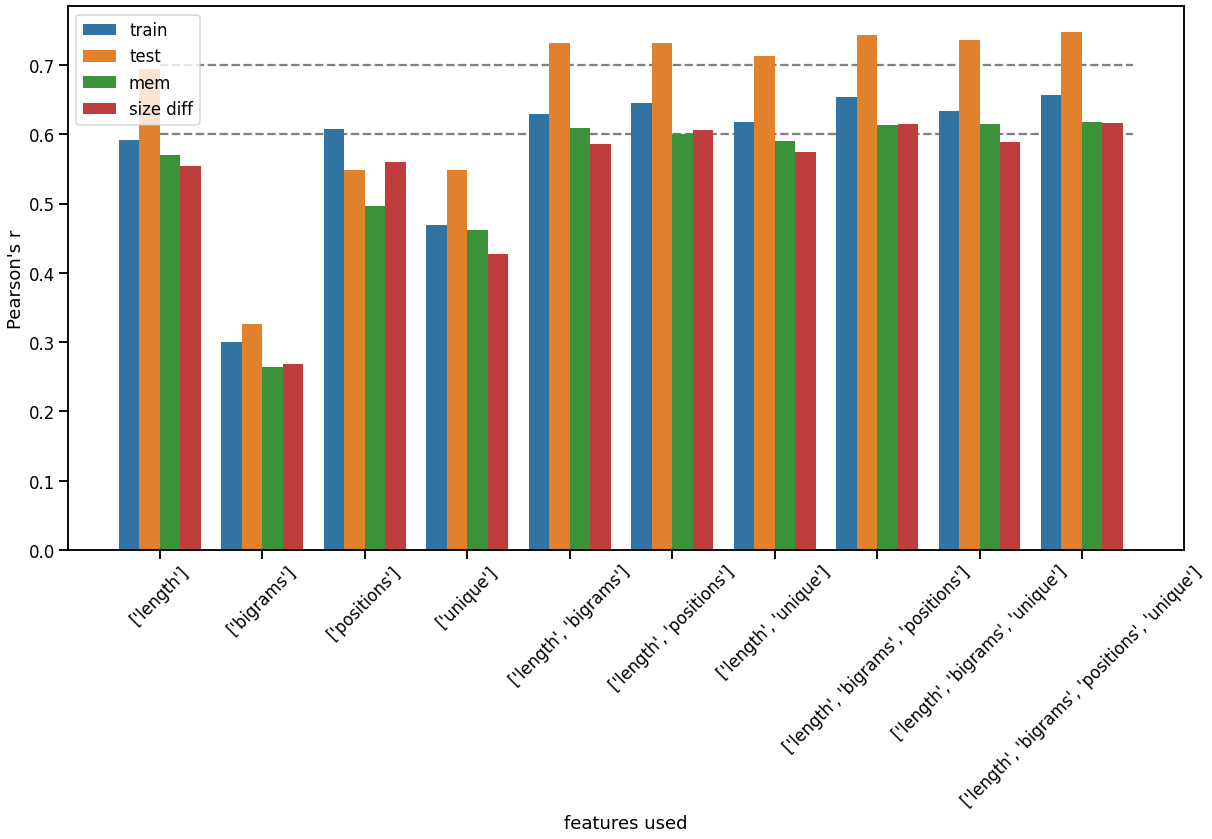

In [47]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=x, y=y, hue=hue)
plt.legend(loc=(1.05, 1))
ax.set_xticklabels([["length"], ["bigrams"], ["positions"], ["unique"],
              ["length", "bigrams"], ["length", "positions"], ["length", "unique"],
              ["length", "bigrams", "positions"], ["length", "bigrams", "unique"],
              ["length", "bigrams", "positions", "unique"]], rotation=45)
sns.lineplot(x=[0, 9.5], y=[0.6, 0.6], zorder=-1, color="grey", linestyle='--')
sns.lineplot(x=[0, 9.5], y=[0.7, 0.7], zorder=-1, color="grey", linestyle='--')
plt.xlabel("features used")
plt.ylabel("Pearson's r")

In [21]:
x

[('length',), ('bigrams',), ('positions',), ('unique',)]

In [22]:
y

[0.5917324820038256,
 0.30037126178782875,
 0.6080705028063178,
 0.4692581779323046]

In [37]:
from collections import defaultdict, Counter
import os


def load_datasets(model="regular", postfix="_last", use_accuracy=False, start=1, stop=40):
    train_scores = defaultdict(list)
    test_scores = defaultdict(list)
    for i in range(start, stop):
        train_file = f"../modelling/memorisation_training/data/{model}_{i}/train{postfix}.out.src-hyp-tgt"
        test_file = f"../modelling/memorisation_training/data/{model}_{i}/test{postfix}.out.src-hyp-tgt"
        if os.path.exists(train_file) and \
           os.path.exists(test_file):
            train = open(train_file,
                encoding="utf-8").readlines()
            test = open(test_file,
                encoding="utf-8").readlines()

            for l in train:
                if len(l.split("\t")) == 4:
                    src, hyp, trg, score = l.split('\t')
                else:
                    src, hyp, trg, score, _, _ = l.split('\t')
                if hyp != trg:
                    continue
                score = 2**(float(score.strip())) if not use_accuracy else hyp.strip() == trg.strip()
                train_scores[(src, trg)].append(score)

            for l in test:
                if len(l.split("\t")) == 4:
                    src, hyp, trg, score = l.split('\t')
                else:
                    src, hyp, trg, score, _, _ = l.split('\t')
                if hyp != trg:
                    continue
                score = 2**(float(score.strip())) if not use_accuracy else hyp.strip() == trg.strip()
                test_scores[(src, trg)].append(score)
    memorisation = Counter({x: np.mean(train_scores[x]) - np.mean(test_scores[x])
                            for x in train_scores if x in test_scores and len(train_scores[x]) > 5 and \
                             and len(test_scores[x]) > 5})
    return memorisation, dict(train_scores), dict(test_scores)

SyntaxError: invalid syntax (1619351543.py, line 39)

In [38]:
import random

def visualise(train_scores, test_scores, postfix):
    x, y, hue, exception = [], [], [], []
    for s in train_scores:
        x.append(np.mean(train_scores[s]))
        y.append(np.mean(test_scores[s]))
        hue.append(round(np.mean(train_scores[s]) - np.mean(test_scores[s]), 1))
    data = {'train': x, 'test': y, 'hue': hue}
    grid = sns.jointplot(data=data, x='train', y='test', hue='hue',
                  joint_kws={'alpha': 1}, linewidth=0, palette="Spectral")
    grid.ax_joint.plot([0, 1], [0, 1], linestyle='--', color="black")
    grid.ax_joint.set_xlim(0, 1)
    grid.ax_joint.set_ylim(0, 1)
    plt.show()

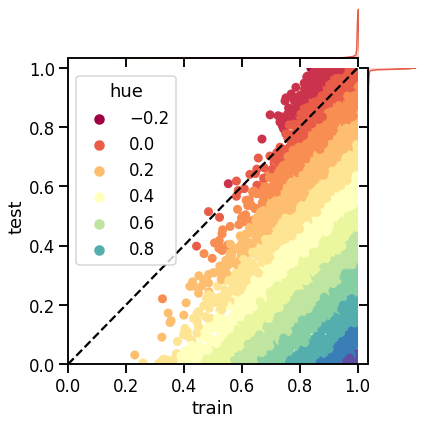

In [39]:
mem, train_scores, test_scores = load_datasets(model="tiny", postfix="100_ref", start=1, stop=41)
visualise(train_scores, test_scores, "_last_ref")

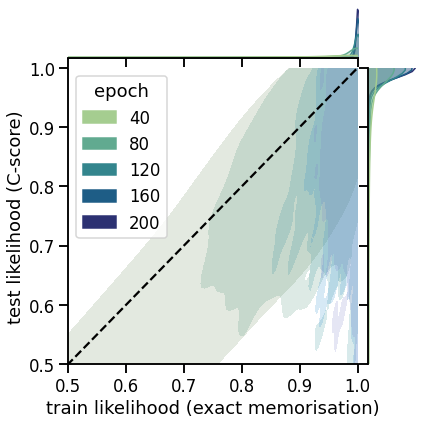

In [40]:
import random
import numpy as np

xlabel = 'train likelihood (exact memorisation)'
ylabel = 'test likelihood (C-score)'

def visualise_epochs(all_data):
    x, y, hue = [], [], []
    for train_scores, test_scores, epoch in all_data:
        for s in train_scores:
            if random.random() < 0.25 and s in test_scores:
                x.append(np.mean(train_scores[s]))
                y.append(np.mean(test_scores[s]))
                hue.append(epoch)
    data = {xlabel: x, ylabel: y, 'epoch': hue}
    grid = sns.jointplot(data=data, x=xlabel, y=ylabel, hue='epoch', kind="kde",
        joint_kws={'levels': 2, 'fill': True, 'alpha': 0.2}, palette="crest", label='epoch',
        legend=True)
#     grid.ax_joint.legend(fontsize=10, title_fontsize=10, title="epoch", frameon=False)
    grid.ax_joint.plot([0, 1], [0, 1], linestyle='--', color="black")
    grid.ax_joint.set_xlim(0.5, 1)
    grid.ax_joint.set_ylim(0.5, 1)
    plt.show()


# all_data = []
# for epoch in [40, 80, 120, 160, 200]:
#     print(epoch)
#     mem, train_scores, test_scores = load_datasets(model="tiny", postfix=f"{epoch}_ref", start=1, stop=40)
#     all_data.append((train_scores, test_scores, epoch))
visualise_epochs(all_data)